<a href="https://colab.research.google.com/github/rubychen8407/MURA-X-ray-classification/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Apr  1 05:13:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setting environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mount google drive by excuting the above cell

In [ ]:
import tensorflow as tf
print(tf.__version__, tf.__file__)
import keras
print(keras.__version__, keras.__file__)

2.4.1 /usr/local/lib/python3.7/dist-packages/tensorflow/__init__.py
2.4.3 /usr/local/lib/python3.7/dist-packages/keras/__init__.py


# Import package

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間
train_generator = train_datagen.flow_from_directory( # 從文件夾中產生數據流
    directory="/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/train", # 訓練集圖片的文件夾
    target_size=(224, 224), # 調整後每張圖片的大小
    batch_size=32,
)

Found 9032 images belonging to 3 classes.


In [ ]:
import numpy as np
import os 
from drive.Shareddrives.深度學習於生醫資料分析_1092.Code.utils import util
#使用汪汪的工具模組，使用方法請用 help() 指令來查詢

help(util)

Help on module drive.Shareddrives.深度學習於生醫資料分析_1092.Code.utils.util in drive.Shareddrives.深度學習於生醫資料分析_1092.Code.utils:

NAME
    drive.Shareddrives.深度學習於生醫資料分析_1092.Code.utils.util - Utilities for deep learning.

CLASSES
    builtins.object
        Img_reader
    
    class Img_reader(builtins.object)
     |  Img_reader(path, label_name=None, size=(512, 512, 1), rescale=None)
     |  
     |  Read image data in a multi-threaded manner,
     |      automatically classify it according to the subdirectories,
     |      and process it into data and labels.
     |  
     |  Args:
     |      path: A string,
     |          the path of the image data.
     |  
     |      label_name: A list,
     |          Optional list of class subdirectories (e.g. ['dogs', 'cats']).
     |          Default: None. If not provided,
     |          the list of classeswill be automatically
     |          inferred from the subdirectory names/structure under directory.
     |  
     |      size: A tuple of int

# Loading images

In [ ]:
#先建立訓練資料用的圖片資料讀取物件
train_reader = util.Img_reader(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/train", # 訓練集圖片的文件夾
    size = (224,224,3), # 調整後每張圖片的大小
    rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

label_name = train_reader.label_name
print(label_name) #訓練資料的標籤名 list

['ELBOW_negative', 'SHOULDER_negative', 'WRIST_negative']


> 以上 rescale 的技巧稱為資料正規化(normalization)，此操作是為了讓輸入資料和 weights 有相似的 range，以避免需花費額化的時間成本在調整超參數上(例如 learning rate)。



In [ ]:
train_data, train_label = train_reader.read_by_thread(
    thread_num = 1000,  #指定要使用多少線程
    shuffle = True)  #是否打亂資料集順序

Found 9032 images belonging to 3 classes.
100%




> 以上方法與 keras 的 flow_from_directory() 不同之處在於，這是直接將資料讀進系統的 ram 中，而 keras 是以 generator 的形式產生資料，所以每次皆會重新讀取，能省去大量記憶體空間。然而對雲端環境來說，每次讀檔就要下載一次資料，因此不適合。



In [ ]:
train_data.shape

(9032, 224, 224, 3)

In [ ]:
train_reader.img_path_list[0]

'/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/train/ELBOW_negative/patient05549_study1_negative_image2.png'

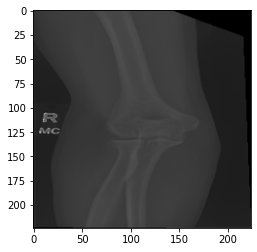

In [ ]:
util.vis_img(train_data[0])

In [ ]:
vali_reader = util.Img_reader(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/valid", # 驗證集圖片的文件夾
    label_name = label_name,
    size = (224,224,3), # 調整後每張圖片的大小
    rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

vali_data,vali_label = vali_reader.read_by_thread(
    thread_num = 1000,  #指定要使用多少線程
    shuffle = True)  #是否打亂資料集順序

In [ ]:
test_reader = util.Img_reader(
    "/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/test", # 測試集圖片的文件夾
    label_name = label_name,
    size = (224,224,3), # 調整後每張圖片的大小
    rescale = 1/255.) # 圖片像素值為0-255，此處都乘以1/255，調整到0-1之間

test_data,test_label = test_reader.read_by_thread(
    thread_num = 1000,  #指定要使用多少線程
    shuffle = False)  #是否打亂資料集順序

Found 2580 images belonging to 3 classes.
100%


In [ ]:
#print(test_reader.img_path_list)

In [ ]:
#test_reader.img_path_list[0]

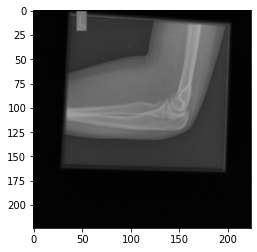

In [ ]:
util.vis_img(test_data[0])

# Model building

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras import Model

Code來源:https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py

In [ ]:
from keras.layers import Dense, Dropout, Flatten

num_classes = 3
input_shape = (224,224,3)
m_model=keras.applications.resnet50.ResNet50(
                    include_top=False, # 是否包含最後的全連接層 (fully-connected layer)
                    weights='imagenet', # None: 權重隨機初始化、'imagenet': 載入預訓練權重
                    input_shape=input_shape, # 當 include_top=False 時，可調整輸入圖片的尺寸（長寬需不小於 32）
                    classes=num_classes)


#x=Dense(num_classes, activation='softmax')(m_model.layers[-1].output)
# 重新建立模型結構
#m_model=Model(m_model.input,x)

94773248/94765736 [==============================] - 10s 0us/step


In [ ]:
x = m_model.layers[-1].output #抽掉全連接層
x = Flatten(name='flatten')(x) # 降成1-D
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# Create your own model 
m_model = Model(m_model.input, x) 
m_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
len(m_model.layers)

177

In [ ]:
#from keras.layers import Dense, Dropout, Flatten

"""
x = m_model.layers[-1].output #抽掉全連接層
x = Flatten(name='flatten')(x) # 降成1-D
x = Dropout(0.5)(x) # 增加 DropOut layer
x = Dense(num_classes, activation='softmax', name='predictions')(x)

# Create your own model 
m_model = Model(m_model.input, x) 
m_model.summary()

# 加一層，只辨識2類
#from keras.layers import Dense


#改變output
#x = m_model.output
#x = Flatten()(x)
#x = Dropout(0.5)(x) # 增加 DropOut layer
#x=Dense(num_classes, activation='softmax', name='softmax')(x)
# 重新建立模型結構
#model=Model(model.input,x)"""

"\nx = m_model.layers[-1].output #抽掉全連接層\nx = Flatten(name='flatten')(x) # 降成1-D\nx = Dropout(0.5)(x) # 增加 DropOut layer\nx = Dense(num_classes, activation='softmax', name='predictions')(x)\n\n# Create your own model \nm_model = Model(m_model.input, x) \nm_model.summary()\n\n# 加一層，只辨識2類\n#from keras.layers import Dense\n\n\n#改變output\n#x = m_model.output\n#x = Flatten()(x)\n#x = Dropout(0.5)(x) # 增加 DropOut layer\n#x=Dense(num_classes, activation='softmax', name='softmax')(x)\n# 重新建立模型結構\n#model=Model(model.input,x)"

資料來源:https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-syste/

https://avacheng.github.io/post/20190817/

In [ ]:
#print(m_model.summary())

In [ ]:
#keras.utils.plot_model(m_model, "my_first_model_with_shape_info.png", show_shapes=True)

# Compile the model

In [ ]:
from tensorflow.keras.optimizers import Adam

m_model.compile(
    loss='sparse_categorical_crossentropy', #因標籤為整數資料，故使用此損失函數
    optimizer=Adam(lr=0.0001),  #lr:學習率(learning rate)
    metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="/content/drive/MyDrive/Colab_Notebooks/ResNet50_weights-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Start training

In [ ]:
train_history = m_model.fit(
    train_data, train_label,
    epochs=13,
    verbose=1, #verbose:詳細信息模式，0或者1
    callbacks=callbacks_list,
    validation_data=(vali_data, vali_label),
    batch_size=32, #12之後就沒改進
    )

# Save model

In [ ]:
m_model.save("/content/drive/MyDrive/Colab_Notebooks/ResNet50_model6")

# Draw the training processing plot

In [ ]:
from tensorflow.keras.models import load_model
m_model = load_model("/content/drive/MyDrive/Colab_Notebooks/ResNet50_model6")

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('Train_History_accuracy.png')

plt.show()

NameError: ignored

In [ ]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Train_History_loss.png')

plt.show()

In [ ]:
scores = m_model.evaluate(train_data, train_label)
print("train_acc:", scores[1])

In [ ]:
vali_scores = m_model.evaluate(vali_data, vali_label)
print("valid_acc:", vali_scores[1])

# Testing

In [ ]:
from tensorflow.keras.models import load_model
m_model = load_model("/content/drive/MyDrive/Colab_Notebooks/ResNet50_model6")

KeyboardInterrupt: ignored

In [ ]:
test_scores = m_model.evaluate(test_data, test_label)
print("test_acc:", test_scores[1])

81/81 [==============================] - 36s 58ms/step - loss: 0.0473 - accuracy: 0.9857
test_acc: 0.9856589436531067


In [ ]:
pred = m_model.predict(test_data)
predicted_class_indices = np.argmax(pred, axis=1)
print(predicted_class_indices)

In [ ]:
i = 0

util.vis_img(test_data[i])
print("prediction:", label_name[predicted_class_indices[i]])

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix


CNN_confusion_matrix = confusion_matrix(test_label, predicted_class_indices)
print(CNN_confusion_matrix)

[[ 567   10    8]
 [   5  837    0]
 [   3   11 1139]]


# **PCA**

In [ ]:
from keras.models import Model

layer_name = 'conv3_block4_add'
intermediate_layer_model = Model(m_model.input, m_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_data)

from sklearn.preprocessing import StandardScaler
import pandas as pd
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = intermediate_output
# Separating out the target

target = pd.DataFrame(data=np.array(test_label),columns = ['target'])

In [ ]:
shape=x.shape
print(shape)

(2580, 28, 28, 512)


In [ ]:
#As you can see above, it’s a 3-dimensional array. We must convert it to 1-dimension as all the upcoming techniques only take 1-dimensional input. To do this, we need to flatten the images:
image = []
for i in range(0,2580):
    img = x[i].flatten()
    image.append(img)
image = np.array(image)
# Standardizing the features
#image = StandardScaler().fit_transform(image)

In [ ]:
"""feat_cols = ['pixel'+str(i) for i in range(image.shape[1])]
df = pd.DataFrame(image,columns=feat_cols)
df['label'] = train_df['benign_malignant'][:2580]
df['label1'] = train_df['target'][:2580]"""

"feat_cols = ['pixel'+str(i) for i in range(image.shape[1])]\ndf = pd.DataFrame(image,columns=feat_cols)\ndf['label'] = train_df['benign_malignant'][:2580]\ndf['label1'] = train_df['target'][:2580]"

In [ ]:
"""from sklearn.decomposition import PCA 
pca = PCA(n_components=2, random_state=42).fit_transform(df[feat_cols].values)
pca_data = np.vstack((pca.T, df['label1'])).T
pca_df = pd.DataFrame(pca_data, columns=['1st Component', '2nd Component', 'Label'])
sns.FacetGrid(pca_df, hue="Label", size=10).map(plt.scatter, "1st Component", "2nd Component").add_legend()
plt.show()"""

'from sklearn.decomposition import PCA \npca = PCA(n_components=2, random_state=42).fit_transform(df[feat_cols].values)\npca_data = np.vstack((pca.T, df[\'label1\'])).T\npca_df = pd.DataFrame(pca_data, columns=[\'1st Component\', \'2nd Component\', \'Label\'])\nsns.FacetGrid(pca_df, hue="Label", size=10).map(plt.scatter, "1st Component", "2nd Component").add_legend()\nplt.show()'

In [ ]:
"""from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)"""

'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nx = scaler.fit_transform(x)'

In [ ]:
#print(image)

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(image)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent1', 'principalcomponent2'])

principalDf = pd.concat([principalDf,target],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "target"] 
#finalDf = pd.concat([principalDf, target], axis = 1)

print(len(principalDf))
principalDf.head()

2580


principalcomponent1  principalcomponent2  target
0           105.750641           -93.037788     0.0
1           -39.704945            -7.592510     0.0
2           -88.832710           -10.436584     0.0
3           172.782867           -90.814560     0.0
4          -154.132919            -1.480816     0.0

In [ ]:
#len(principalComponents)

<Figure size 936x720 with 0 Axes>

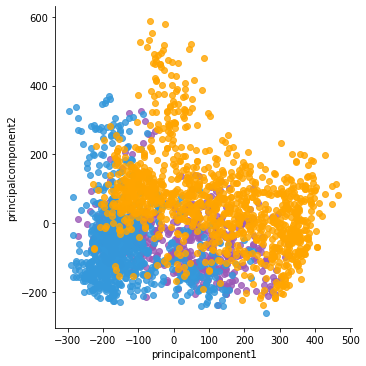

<Figure size 936x720 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)

sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False,
           hue="target", legend=False)

plt.figure(figsize=(13,10))

In [ ]:
colors = ['r', 'g', 'b']
targets= [0.0, 1.0, 2.0]

2580
2580
2580
7740


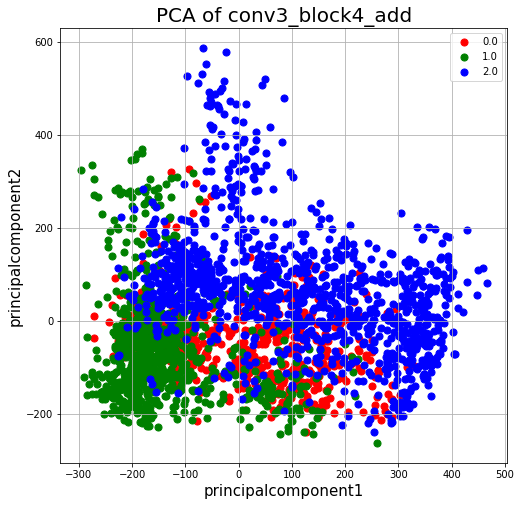

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principalcomponent1', fontsize = 15)
ax.set_ylabel('principalcomponent2', fontsize = 15)
ax.set_title('PCA of conv3_block4_add', fontsize = 20)
#plt.xlim((min("principalcomponent1")), max("principalcomponent1"))
#plt.ylim((min("principalcomponent2"), max("principalcomponent2")))
count = 0
for target, color in zip(targets,colors):
  indicesToKeep = principalDf['target'] == target
  print(len(indicesToKeep))
  ax.scatter(principalDf.loc[indicesToKeep, 'principalcomponent1']
            , principalDf.loc[indicesToKeep, 'principalcomponent2']
             , c = color
             , s = 50) 
  count += len(indicesToKeep)
print(count)
ax.legend(targets)
ax.grid()
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.05322417, 0.02900022], dtype=float32)

In [ ]:
#cumulate explained
np.array([pca.explained_variance_ratio_[:i].sum() for i in range(0, 3)]).round(2)

array([0.  , 0.05, 0.08], dtype=float32)

In [ ]:
"""可以跑開平方根整除的維度
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fig, axarr = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(pca.components_[0, :].reshape(int(100352**0.5), int(100352**0.5)), ax=axarr[0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(100352**0.5, 100352**0.5), ax=axarr[1], cmap='gray_r')
axarr[0].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
    fontsize=12
)
axarr[1].set_title(
    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
    fontsize=12
)
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

plt.suptitle('2-Component PCA')"""

'可以跑開平方根整除的維度\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nplt.style.use(\'fivethirtyeight\')\n\nfig, axarr = plt.subplots(1, 2, figsize=(12, 4))\n\nsns.heatmap(pca.components_[0, :].reshape(int(100352**0.5), int(100352**0.5)), ax=axarr[0], cmap=\'gray_r\')\nsns.heatmap(pca.components_[1, :].reshape(100352**0.5, 100352**0.5), ax=axarr[1], cmap=\'gray_r\')\naxarr[0].set_title(\n    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),\n    fontsize=12\n)\naxarr[1].set_title(\n    "{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),\n    fontsize=12\n)\naxarr[0].set_aspect(\'equal\')\naxarr[1].set_aspect(\'equal\')\n\nplt.suptitle(\'2-Component PCA\')'

# **3d**

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
#x = intermediate_output
# Separating out the target

#target = pd.DataFrame(data=np.array(test_label),columns = ['target'])
# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [ ]:
print(principalDf['target'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2575    2.0
2576    2.0
2577    2.0
2578    2.0
2579    2.0
Name: target, Length: 2580, dtype: float64


In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(image)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=principalDf['target'],
    title=f'Total Explained Variance: {total_var:.2f}%', 
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}) #
fig.show()

In [ ]:
np.array([pca.explained_variance_ratio_[:i].sum() for i in range(0, 5)]).round(2)

array([0.  , 0.57, 0.68, 0.75, 0.75], dtype=float32)

In [ ]:
pca.explained_variance_ratio_

array([0.5670815 , 0.11038294, 0.06825188], dtype=float32)

# **T-SNE**
https://ownyulife.top/2019/05/09/dimension-function-all/

In [ ]:
from keras.models import Model

layer_name = 'conv3_block4_add'
intermediate_layer_model = Model(m_model.input, m_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_data)

from sklearn.preprocessing import StandardScaler
import pandas as pd
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = intermediate_output
target = pd.DataFrame(data=np.array(test_label),columns = ['target'])
# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [ ]:
#FLATTEN
image = []
for i in range(0,2580):
    img = x[i].flatten()
    image.append(img)
x = np.array(image)
# Standardizing the features
#image = StandardScaler().fit_transform(image)"""

In [ ]:
import numpy as np
x = np.vstack(x) # Place the arrays of data of each digit on top of each other and store in X
y = np.hstack(np.array(test_label))# Place the arrays of data of each target digit by the side of each other continuosly and store in Y

In [ ]:
from sklearn import manifold, datasets
'''t-SNE'''
tsne = manifold.TSNE(n_components=2, init='random', random_state=501) #設定pca init不好
x_tsne = tsne.fit_transform(x)

print("Org data dimension is {}. Embedded data dimension is {}".format(x.shape[-1], x_tsne.shape[-1]))

In [ ]:
color={0.0:'r', 1.0:'g', 2.0:'b'}
color.get(0)


In [ ]:
'''嵌入空间可视化'''

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

x_min, x_max = x_tsne.min(0), x_tsne.max(0)
x_norm = (x_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
#ax.set_xlabel('principalcomponent1', fontsize = 15)
##ax.set_ylabel('principalcomponent2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
"""
for i in range(x_norm.shape[0]):
  plt.text(x_norm[i, 0], x_norm[i, 1],str(y[i]), color=plt.cm.Set1(y[i]),
             fontdict={'weight': 'bold', 'size': 9})"""
  
color={0.0:'r', 1.0:'g', 2.0:'b'}
for i in range(0,2058):
  plt.scatter(x_norm[i, 0], x_norm[i, 1], c=color[test_label[i]], s=5)

targets=[0,1,2]
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('T-SNE of conv3_block4_add layer')
red_cir=mpatches.Patch(color='red', label='Elbow')
green_cir=mpatches.Patch(color='green', label='Shoulder')
blue_cir=mpatches.Patch(color='blue', label='Wrist')

plt.legend(handles=[red_cir,green_cir,blue_cir])#https://matplotlib.org/3.3.3/tutorials/intermediate/legend_guide.html
plt.grid()
plt.show()

In [ ]:
x_norm.shape[0]

# **UMAP**

In [ ]:
from keras.models import Model

layer_name = 'conv3_block4_add'
intermediate_layer_model = Model(m_model.input, m_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(test_data)

from sklearn.preprocessing import StandardScaler
import pandas as pd
#features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = intermediate_output
target = pd.DataFrame(data=np.array(test_label),columns = ['target'])
# Standardizing the features
#x = StandardScaler().fit_transform(x)

In [ ]:
#FLATTEN
image = []
for i in range(0,2580):
    img = x[i].flatten()
    image.append(img)
x = np.array(image)
# Standardizing the features

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [ ]:
pip install umap-learn

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(random_state=42)
reducer.fit(x)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
embedding = reducer.transform(x)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(2580, 2)

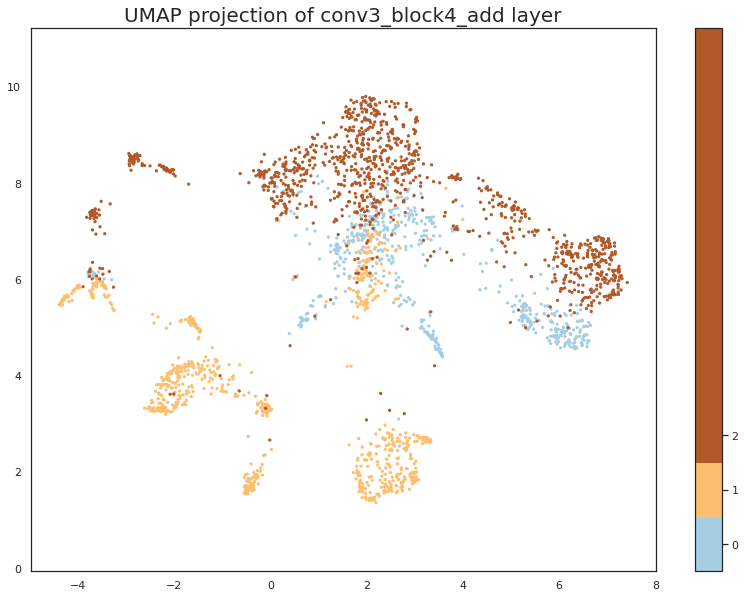

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=test_label, cmap='Paired', s=5)
plt.gca().set_aspect('equal', 'datalim') #繪製正方形及datalimit
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(3))
plt.title('UMAP projection of conv3_block4_add layer', fontsize=20);

# **find misclassfied image**

In [ ]:
misclassified_images_labels = []
mis_id=[]
for i in range(0,2580):
  # Get true data
  im=i #第幾張圖片
  true_label = test_label[i]
  
  # Get predicted label from your classifier
  predicted_label = predicted_class_indices[i]
  
  # Compare true and predicted labels
  if(predicted_label != true_label):
    # If these labels are not equal, the image has been misclassified
    misclassified_images_labels.append((i, predicted_label, true_label))
    mis_id.append(i)

NameError: ignored

In [ ]:
print(misclassified_images_labels)

In [ ]:
len(misclassified_images_labels) #22張分錯

In [ ]:
test_reader.img_path_list[5]

In [ ]:
util.vis_img(test_data[1223])

In [ ]:
print(predicted_class_indices[1223])

In [ ]:
print(test_label[1223])

# **Gra-CAM algorithm**

In [ ]:
!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git

Cloning into 'tf_keras_gradcamplusplus'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 92 (delta 30), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [ ]:
# %%
from tf_keras_gradcamplusplus.utils import preprocess_image, show_imgwithheat
from tf_keras_gradcamplusplus.gradcam import grad_cam,grad_cam_plus

SHOULDER


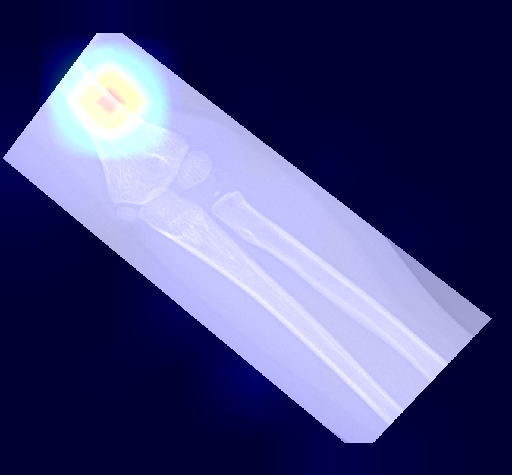

ELBOW


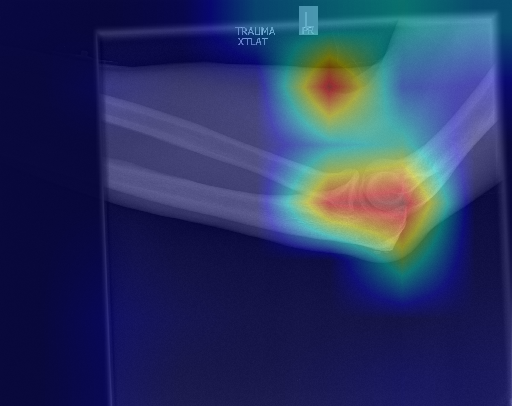

SHOULDER


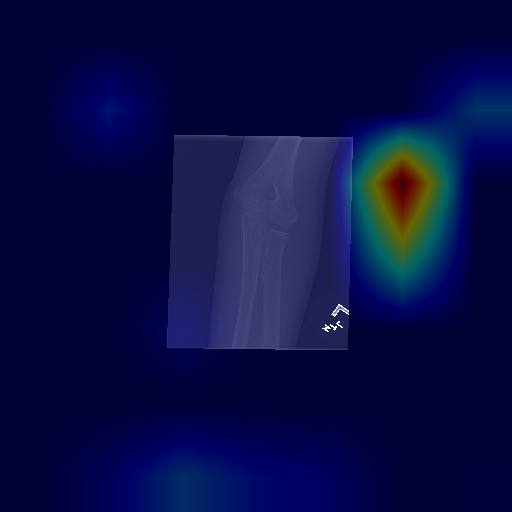

SHOULDER


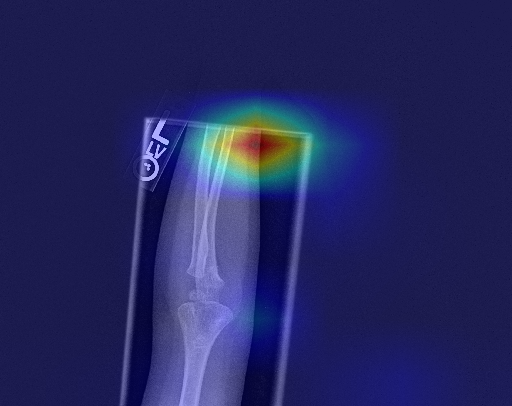

ELBOW


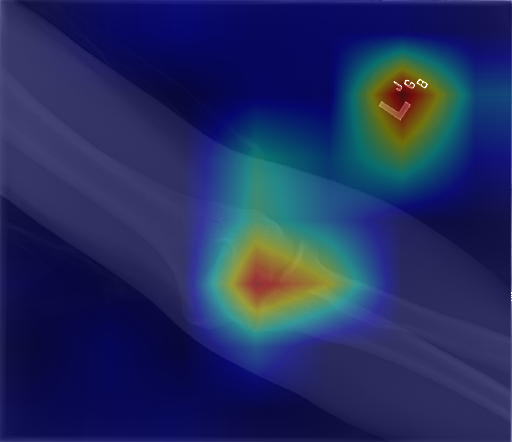

SHOULDER


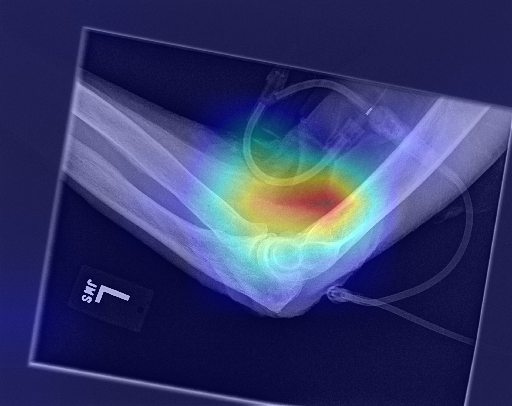

SHOULDER


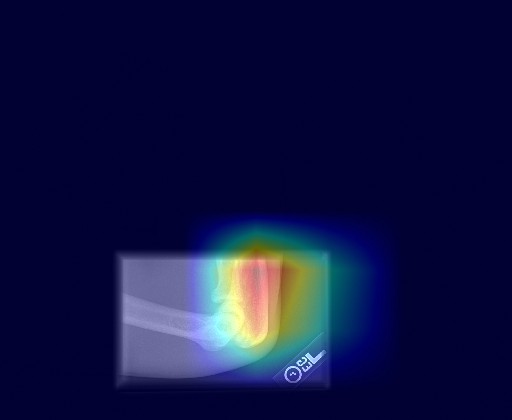

WRIST


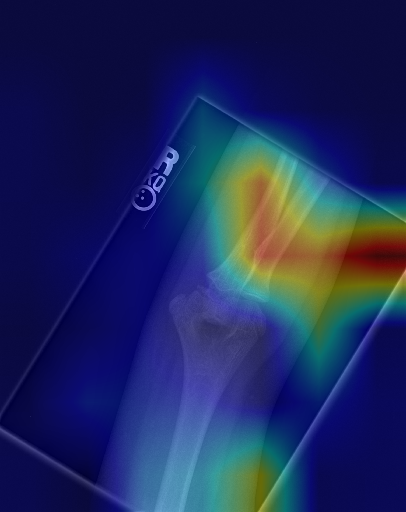

ELBOW


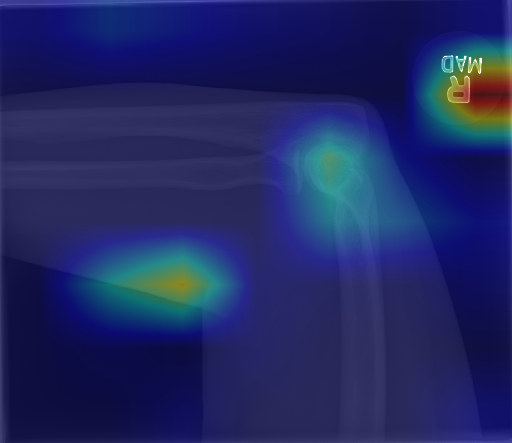

ELBOW


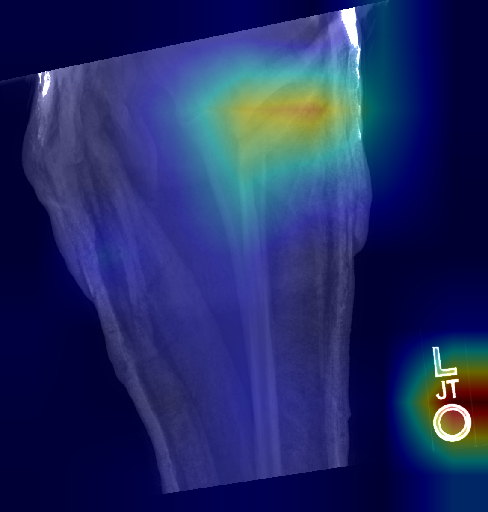

ELBOW


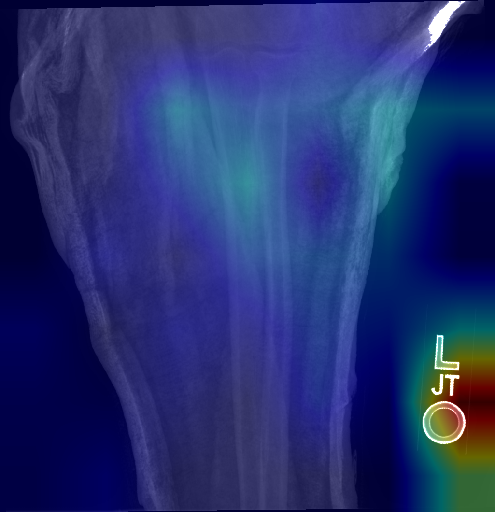

SHOULDER


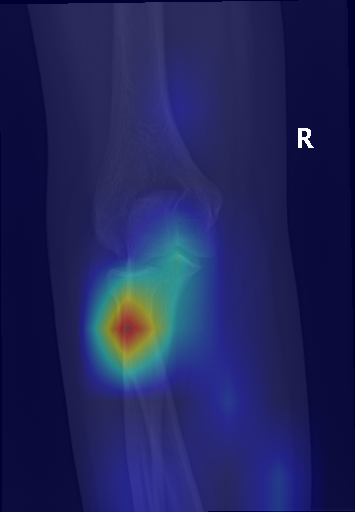

ELBOW


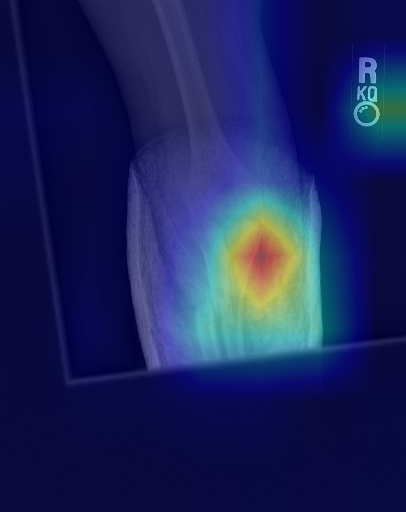

ELBOW


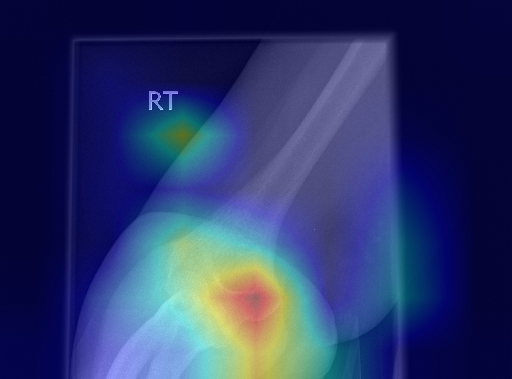

ELBOW


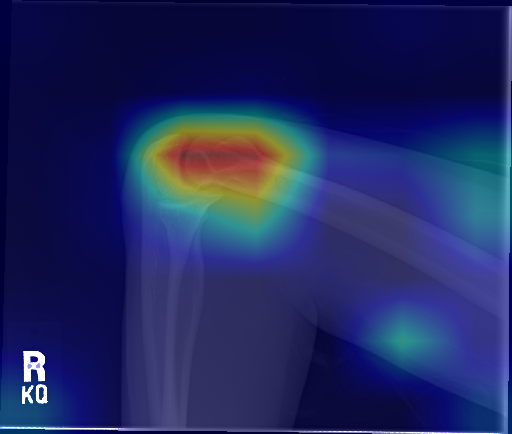

SHOULDER


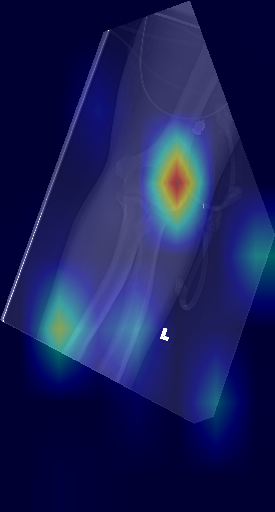

ELBOW


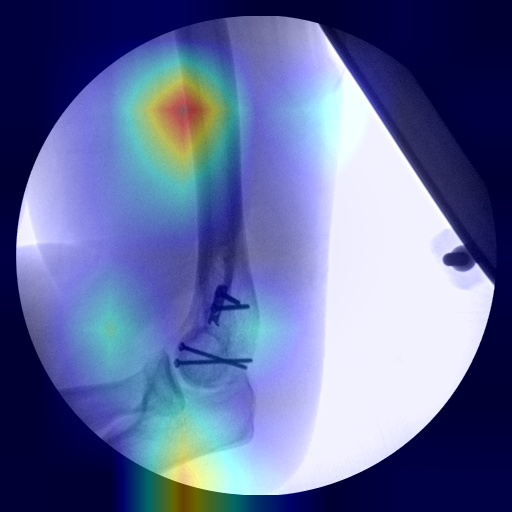

ELBOW


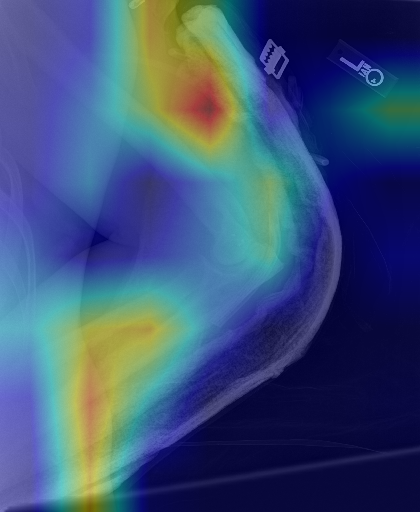

ELBOW


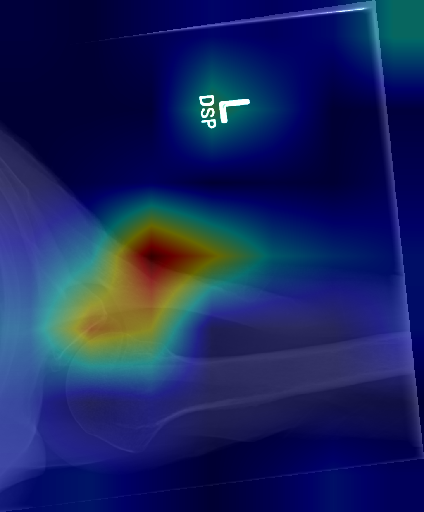

WRIST


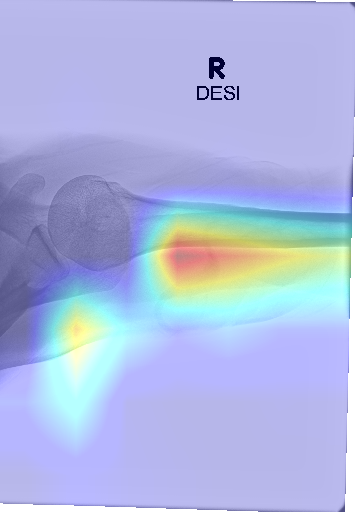

WRIST


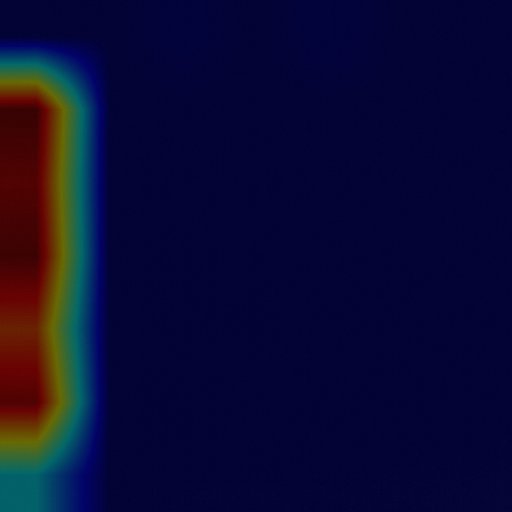

WRIST


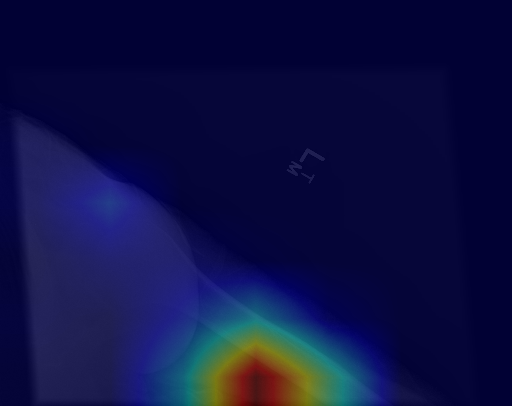

ELBOW


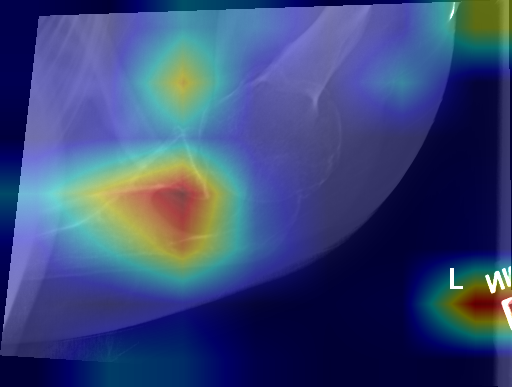

ELBOW


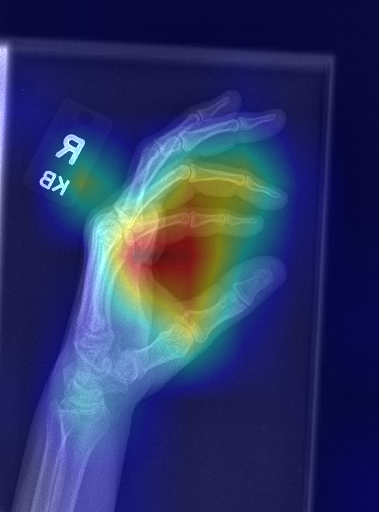

ELBOW


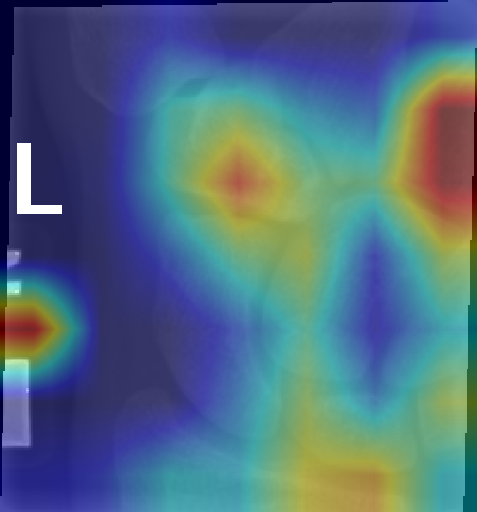

ELBOW


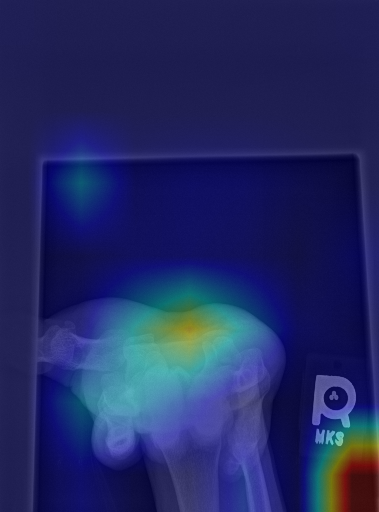

ELBOW


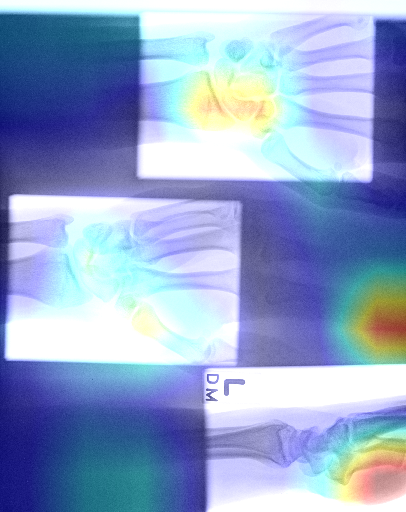

ELBOW


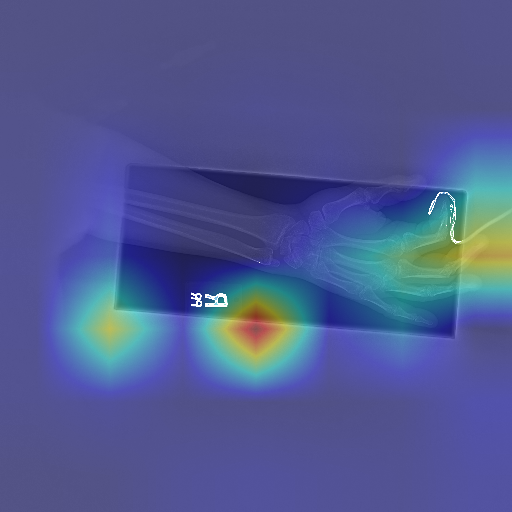

SHOULDER


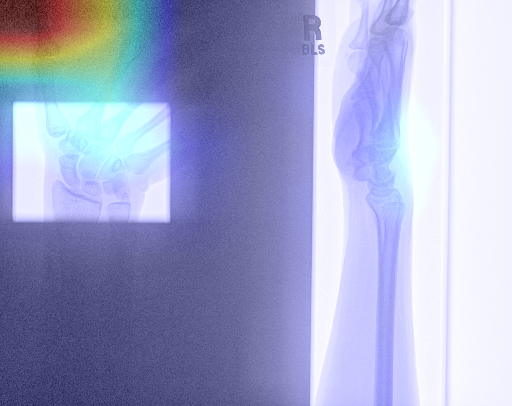

WRIST


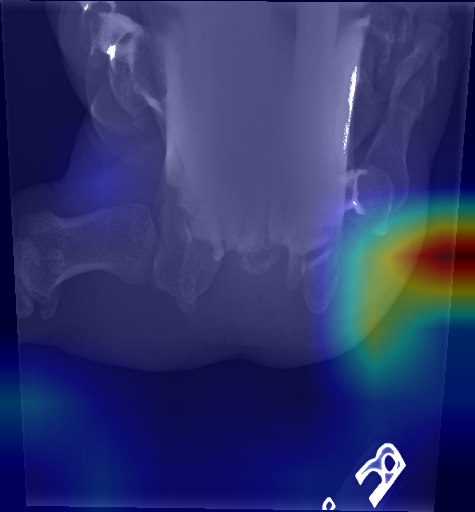

WRIST


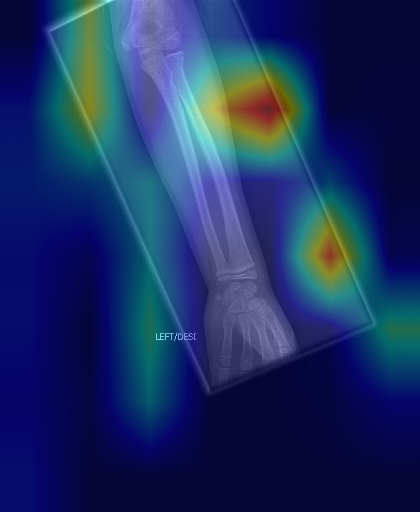

ELBOW


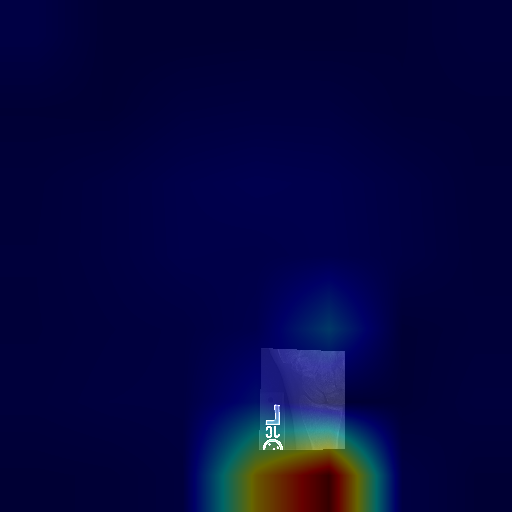

WRIST


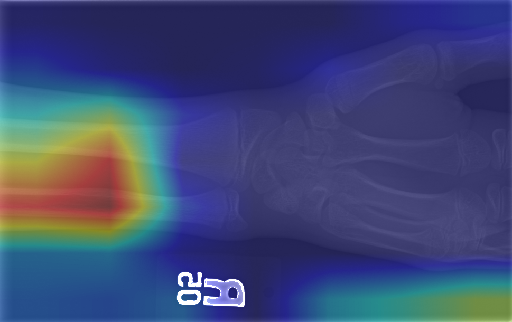

ELBOW


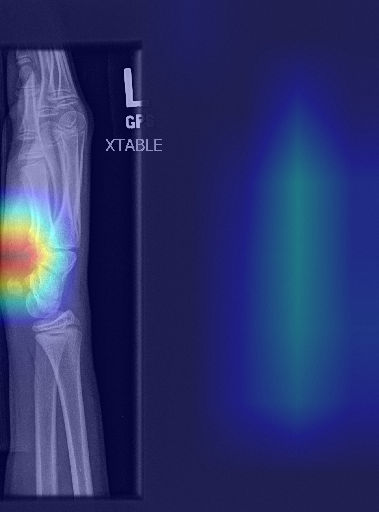

ELBOW


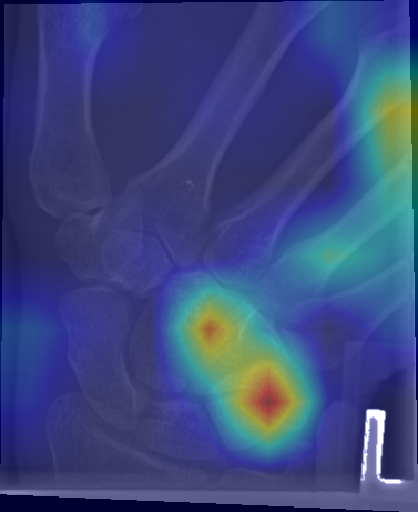

WRIST


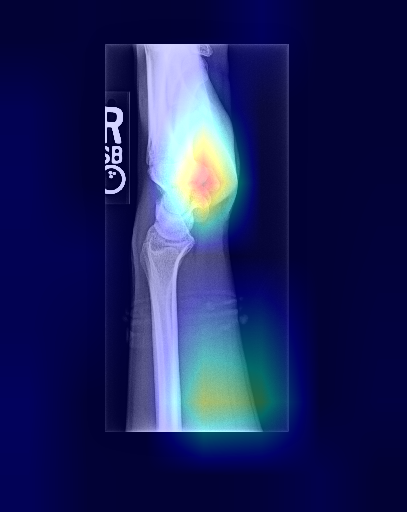

ELBOW


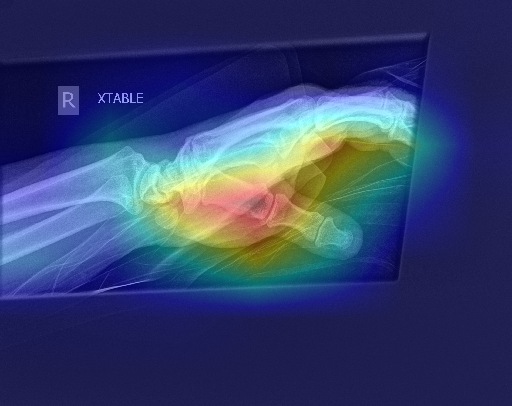

In [ ]:
# %%
for i in mis_id:
  img_path = []
  img_path.append(test_reader.img_path_list[i])
  for n in range(0,len(img_path)):
    img = preprocess_image(img_path[n])
    # %% result of grad cam
    heatmap = grad_cam(m_model, img, layer_name = "conv5_block3_out",
                       label_name = ['ELBOW', 'SHOULDER', 'WRIST'])
    show_imgwithheat(img_path[n], heatmap)

In [ ]:
test_reader.img_path_list[22]

'/content/drive/Shareddrives/深度學習於生醫資料分析_1092/Datasets/MURA/test/ELBOW_negative/patient05760_study1_negative_image2.png'

In [ ]:
util.vis_img(test_data[22])

WRIST


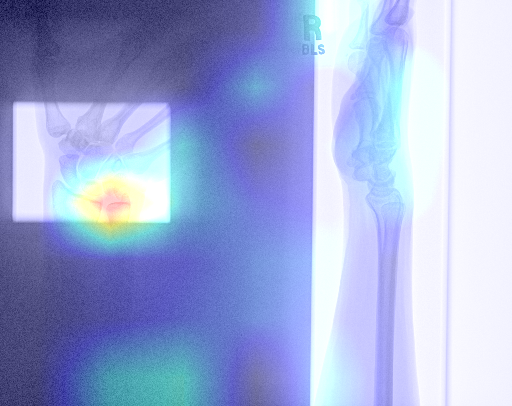

ELBOW


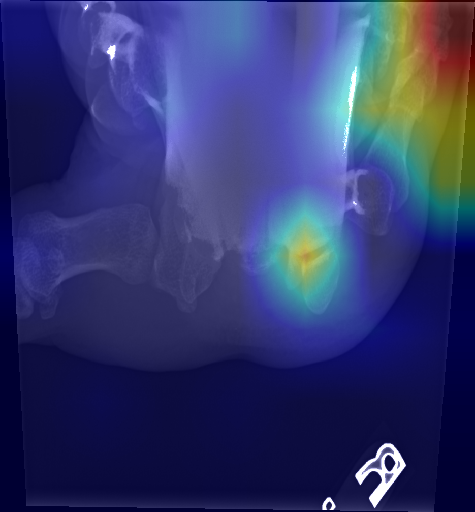

In [ ]:
# %% result of grad cam++

for i in (22,1861):
  img_path = []
  img_path.append(test_reader.img_path_list[i])
  for n in range(0,len(img_path)):
    img = preprocess_image(img_path[n])
    # %% result of grad cam
    heatmap_plus = grad_cam_plus(m_model, img, layer_name = "conv5_block3_out",
                                 label_name = ['ELBOW', 'SHOULDER', 'WRIST'])
    show_imgwithheat(img_path[n], heatmap_plus)

In [ ]:
"""
%cd /content/drive/MyDrive/utils 
#!ls -l gradcam.py
#!ls -l utils.py
#!cat '/content/drive/MyDrive/utils.py'
from drive.MyDrive.utils import utils, gradcam
#from gradcam import grad_cam,grad_cam_plus
#from utils import preprocess_image, show_imgwithheat"""

In [ ]:
"""from matplotlib import cm
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam,GradcamPlusPlus
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
def Grad_CAM_savepictures(file_index,model,save_name):
  def loss(output):
    return (output[0][y_test[file_index]])
  def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
  # Create Gradcam object
  gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)
  originalimage=x_test[file_index]
  originalimage=originalimage.reshape((1,originalimage.shape[0],originalimage.shape[1],1))

  # Generate heatmap with GradCAM
  cam = gradcam(loss,originalimage,penultimate_layer=-1)
  cam = normalize(cam)

  #overlap image
  ax1=plt.subplot(1, 3, 1)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(x_test[file_index].reshape((x_test.shape[1],x_test.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((x_test.shape[1],x_test.shape[2],3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAM")

  gradcam = GradcamPlusPlus(model,model_modifier=model_modifier,clone=False)
  cam = gradcam(loss,originalimage,penultimate_layer=-1)
  cam = normalize(cam)

  ax1=plt.subplot(1, 3, 2)
  heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
  ax1.imshow(x_test[file_index].reshape((x_test.shape[1],x_test.shape[2])),cmap="gray")
  ax1.imshow(heatmap.reshape((x_test.shape[1],x_test.shape[2],3)), cmap='jet', alpha=0.4) # overlay
  ax1.set_title("Grad-CAMPlusPlus")

  plt.savefig(save_name)
  plt.show()"""

In [ ]:
"""https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb
def gradcam(model, x):
    # 取得影像的分類類別
    preds = m_model.predict(x)
    pred_class = np.argmax(preds[0])
    
    # 取得影像分類名稱
    pred_class_name = label_name[predicted_class_indices[i]
    
    # 預測分類的輸出向量
    pred_output = model.output[:, pred_class]
    
    # 最後一層 convolution layer 輸出的 feature map
    # ResNet 的最後一層 convolution layer
    last_conv_layer = model.get_layer('res5c_branch2c')
    
    # 求得分類的神經元對於最後一層 convolution layer 的梯度
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    
    # 求得針對每個 feature map 的梯度加總
    pooled_grads = K.sum(grads, axis=(0, 1, 2))
    
    # K.function() 讓我們可以藉由輸入影像至 `model.input` 得到 `pooled_grads` 與
    # `last_conv_layer[0]` 的輸出值，像似在 Tensorflow 中定義計算圖後使用 feed_dict
    # 的方式。
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # 傳入影像矩陣 x，並得到分類對 feature map 的梯度與最後一層 convolution layer 的 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map 乘以權重，等於該 feature map 中的某些區域對於該分類的重要性
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
        
    # 計算 feature map 的 channel-wise 加總
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap, pred_class_name"""

In [ ]:
"""from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# %%
for id in mis_id:
  img = test_data[id]

# %% result of grad cam
heatmap = grad_cam(m_model, img,
                   label_name = ['WRIST', 'ELBOW', 'SHOULDER'],
                   #category_id = 0,
                   )
show_imgwithheat(img_path, heatmap)

# %% result of grad cam++
heatmap_plus = grad_cam_plus(model, img)
show_imgwithheat(img, heatmap_plus)"""

https://alyxion.github.io/Udacity_IntroToSelfDrivingCarsNd//8_1_Day_Night_Classification_Mini_Projects/47_Accuracy%20and%20Misclassification.html